In [216]:
# Surperformer le buy and hold mais avec une vol plus faible.
#Toutes les méthodes de prévision sont envisageables : 
#les modèles économétriques incluant les modèles de séries temporelles, uni et multivariés; 
#les méthodes de Machine Learning supervisées ou non supervisées y compris les réseaux de neurones; 
#ou d’autres types de modèles comme les algorithmes génétiques.

Les volumes quotidiens échangés sur chacune des 11 crypto-monnaies (timezone UTC). Notons ici que les séries de prix de chaque  crypto-monnaie peuvent servir à prévoir la dynamique de prix des autres crypto-monnaies, si on soupçonne des interdépendances  dynamiques entre les prix des crypto-monnaies.  
Des données sur les prix ou rendements d’autres classes d’actifs et sur l’incertitude macroéconomique (Macrofi and uncertainty)  
  
Les données de sentiment sont obtenues à partir de méthodes de type NLP (Natural Language Processing) appliquées au contenu  des Tweets. Pour chaque crypto-monnaie, on dispose un indicateur quotidien compris en -1 et 1 traduisant le degré d’optimisme  des participants au réseau Twitter sur la progression des prix : plus l’indicateur est élevé plus les messages sont analysés  comme optimistes (haussiers).  
Précisons en n que les équipes ne sont pas tenues de proposer un exercice de prévision sur l’ensemble des 11 crypto-monnaies.  Elles pourront, à leur discrétion, selon leur progression et la pertinence des modèles proposés, se concentrer sur un panier  plus restreint mais incluant au minimum 5 crypto-monnaies.  
  


In [257]:
#ouvre le xlsx Dataset 

import pandas as pd

#ouvre le xlsx Dataset
df = pd.read_excel('Dataset.xlsx')

In [258]:
# Supposons que votre DataFrame s'appelle df
btc_columns = df.filter(like='BTC').columns.tolist() + df.filter(like='btc').columns.tolist()
#sors moi un df avec les colonnes btc, en ajoutant la colonne Date
df_btc = df[btc_columns + ['date']]
#sur la colonne Close, fait un pct change dans une nouvelle colonne Return
df_btc['Return_BTC'] = df_btc['Close_BTC'].pct_change()
#drop la premiere ligne de df_btc
df_btc = df_btc.drop(df_btc.index[0])
# Supposons que 'value' est la colonne contenant les valeurs que vous voulez comparer
df_btc['target'] = (df_btc['Return_BTC'].shift(-1) > df_btc['Return_BTC']).astype(int)
# Supposons que 'date' est la colonne contenant les dates
df_btc['date'] = pd.to_datetime(df_btc['date'])  # Assurez-vous que la colonne est de type datetime
df_btc['year'] = df_btc['date'].dt.year
df_btc['month'] = df_btc['date'].dt.month
df_btc['day'] = df_btc['date'].dt.day
df_btc['day_of_week'] = df_btc['date'].dt.dayofweek  # Lundi=0, Dimanche=6

#fais un fillna 0
df_btc = df_btc.fillna(0)

/var/folders/bn/74x_l6t57mncrtd65lq_drbw0000gn/T/ipykernel_27050/3598607125.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc['Return_BTC'] = df_btc['Close_BTC'].pct_change()


In [259]:
#fais le train de 2017-08 a 2022-08 et le reste en test
df_train = df_btc[df_btc['date'] < '2022-08-01']
df_test = df_btc[df_btc['date'] >= '2022-08-01']
##mets la colonne date en index 
df_train = df_train.set_index('date')
df_test = df_test.set_index('date')

In [260]:
from sklearn.ensemble import RandomForestClassifier

def train_random_forest(df_train, df_test):
    # Séparer les variables explicatives de la variable cible
    train = df_train.drop('target', axis=1)
    train_target = df_train['target']
    test = df_test.drop('target', axis=1)

    # Créer le modèle de forêt aléatoire
    rf = RandomForestClassifier(n_estimators=100, random_state=42)

    # Entraîner le modèle
    rf.fit(train, train_target)

    # Prédire les valeurs de l'ensemble de test
    y_pred = rf.predict(test)

    # Afficher la précision du modèle
    from sklearn.metrics import accuracy_score
    print('Accuracy:', accuracy_score(df_test['target'], y_pred))
    #montre le RMSE 
    from sklearn.metrics import mean_squared_error
    print('RMSE:', mean_squared_error(df_test['target'], y_pred, squared=False))

    #compte le nombre de 0 de df 
    print(df_test['target'].value_counts())
    # Retourner le modèle entraîné et les prédictions
    return rf, y_pred

# Utiliser la fonction
rf_model, y_pred = train_random_forest(df_train, df_test)



Accuracy: 0.6941176470588235
RMSE: 0.5530663187549721
1    87
0    83
Name: target, dtype: int64


In [261]:
from sklearn.preprocessing import StandardScaler

df_btc_scaled = df_btc.copy()

# Obtenir toutes les colonnes sauf la colonne de date
columns_to_scale = df_btc.columns.drop('date', 'target','day','month','year','day_of_week')

scaler = StandardScaler()
df_btc_scaled[columns_to_scale] = scaler.fit_transform(df_btc[columns_to_scale])

df_btc_scaled.head()

TypeError: drop() takes from 2 to 3 positional arguments but 7 were given

In [222]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

X_train = df_train.drop('target',axis=1)
y_train = df_train['target']
X_test = df_test.drop('target',axis=1)
y_test = df_test['target']


# Logistic Regression
logreg = LogisticRegression(random_state=42)
logreg.fit(df_train.drop('target',axis=1), df_train['target'])
y_pred = logreg.predict(df_test.drop('target',axis=1))

# Evaluation: Confusion matrix#
###############################
logreg_acc = accuracy_score(df_test['target'], y_pred)
cm = confusion_matrix(df_test['target'], y_pred) # Confusion matrix
tpr_logreg = cm[1][1] /(cm[1][0] + cm[1][1])

print('The accuracy score is:', logreg_acc) # accuracy score
print('Sensitivity (TPR) =', tpr_logreg)

print('\n Confusion matrix \n \n')
print(classification_report(df_test['target'], y_pred))

#calcule le rmse 
from sklearn.metrics import mean_squared_error
print('RMSE:', mean_squared_error(df_test['target'], y_pred, squared=False))

# plot_confusion_matrix(logreg, df_test.drop('target'), df_test['target'])
# plt.show()

The accuracy score is: 0.5235294117647059
Sensitivity (TPR) = 1.0

 Confusion matrix 
 

              precision    recall  f1-score   support

           0       1.00      0.02      0.05        83
           1       0.52      1.00      0.68        87

    accuracy                           0.52       170
   macro avg       0.76      0.51      0.36       170
weighted avg       0.75      0.52      0.37       170

RMSE: 0.6902684899626333


In [263]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(solver='lsqr', store_covariance=True, random_state=42)
lda.fit(X_train, y_train)
# Predict Test Set Responses #
##############################
y_predicted = lda.predict(X_test)
# convert the predicted probabilities to class 0 or 1
y_predicted= np.array(y_predicted > 0.5, dtype=float)

# Evaluation: Confusion matrix #
###############################
lda_acc = accuracy_score(y_test, y_predicted)  # accuracy score
cm_lda = confusion_matrix(y_test, y_pred) # Confusion matrix 
tpr_lda = cm_lda[1][1] /(cm_lda[1][0] + cm_lda[1][1])

print('Accuracy =', lda_acc)  
print('Sensitivity (TPR) =', tpr_lda)

print('\n Confusion matrix \n \n')
print(classification_report(y_test, y_predicted ))

#calcule le rmse
from sklearn.metrics import mean_squared_error
print('RMSE:', mean_squared_error(y_test, y_predicted, squared=False))

Accuracy = 0.7411764705882353
Sensitivity (TPR) = 0.735632183908046

 Confusion matrix 
 

              precision    recall  f1-score   support

           0       0.73      0.75      0.74        83
           1       0.75      0.74      0.74        87

    accuracy                           0.74       170
   macro avg       0.74      0.74      0.74       170
weighted avg       0.74      0.74      0.74       170

RMSE: 0.5087470190691683


In [231]:
from sklearn.tree import DecisionTreeClassifier
# min_samples_split: The minimum number of samples required to split an internal node
dtree = DecisionTreeClassifier(random_state=42)

# Build classification tree
dtree.fit(X_train, y_train)

y_pred = dtree.predict(X_test)

# Evaluation: Confusion matrix #
################################
dtree_acc = accuracy_score(y_test, y_pred)   # accuracy score
cm_dtree = confusion_matrix(y_test, y_pred) # Confusion matrix 
tpr_dtree = cm_dtree[1][1] /(cm_dtree[1][0] + cm_dtree[1][1])

print("Accuracy:",dtree_acc)
print('Sensitivity (TPR) =', tpr_dtree)
print('\n Confusion matrix \n \n')
print(classification_report(y_test, y_pred ))
#fais le rmse 
from sklearn.metrics import mean_squared_error
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))



Accuracy: 0.6
Sensitivity (TPR) = 0.4367816091954023

 Confusion matrix 
 

              precision    recall  f1-score   support

           0       0.57      0.77      0.65        83
           1       0.67      0.44      0.53        87

    accuracy                           0.60       170
   macro avg       0.62      0.60      0.59       170
weighted avg       0.62      0.60      0.59       170

RMSE: 0.6324555320336759


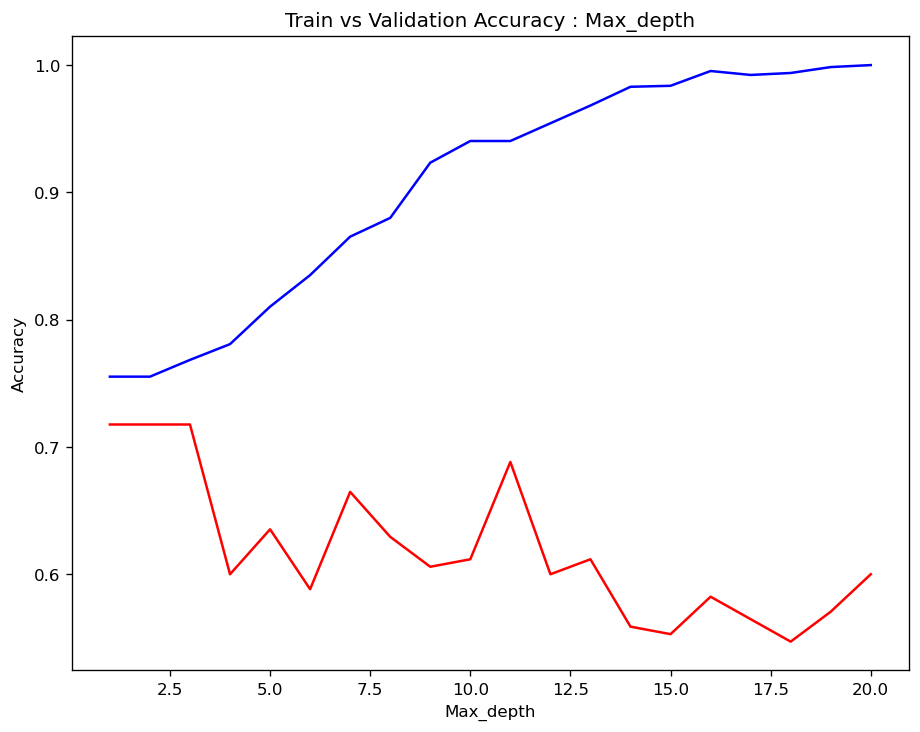

In [232]:
train_acc1 = []
val_acc1 = []

for max_d in range(1,21):
  model = DecisionTreeClassifier(max_depth=max_d, random_state=42)
  model.fit(X_train, y_train)
  train_acc1.append(model.score(X_train, y_train))
  val_acc1.append(model.score(X_test,y_test))

line1, = plt.plot([*range(1,21)], train_acc1, 'b', label='Train accuracy')
line2, = plt.plot([*range(1,21)], val_acc1, 'r', label='Validation accuracy')


plt.title('Train vs Validation Accuracy : Max_depth')
plt.ylabel('Accuracy')
plt.xlabel('Max_depth')
plt.show()

train_acc1.clear()
val_acc1.clear()

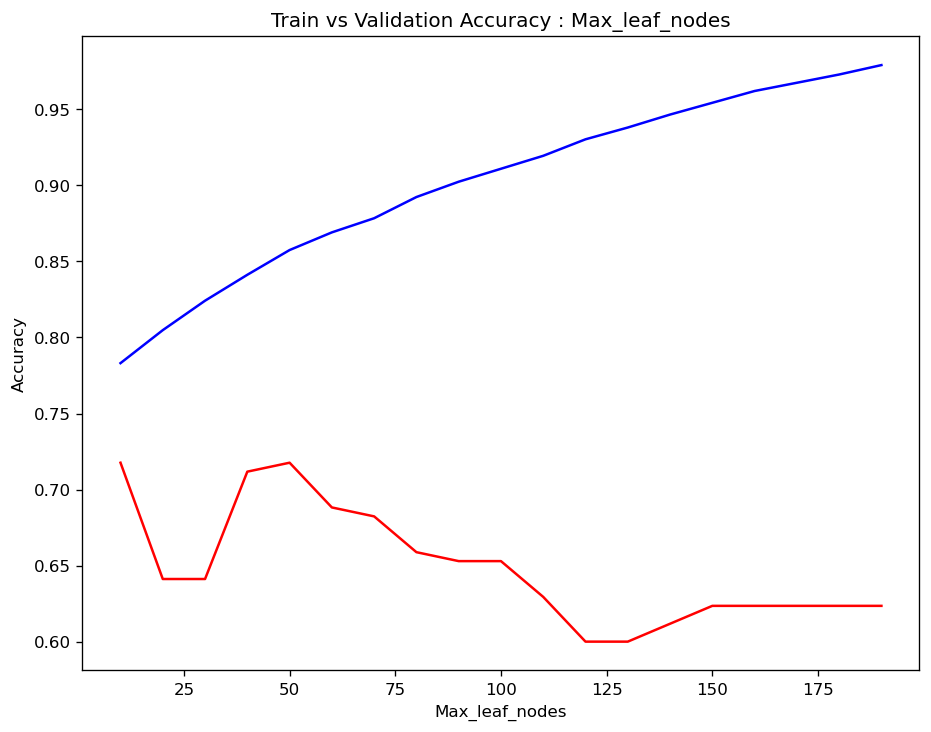

In [233]:
train_acc2 = []
val_acc2 = []

for max_ln in range(10,200,10):
  model2 = DecisionTreeClassifier(max_leaf_nodes=max_ln, random_state=42)
  model2.fit(X_train, y_train)
  train_acc2.append(model2.score(X_train, y_train))
  val_acc2.append(model2.score(X_test,y_test))


line3, = plt.plot([*range(10,200,10)], train_acc2, 'b', label='Train accuracy')
line4, = plt.plot([*range(10,200,10)], val_acc2, 'r', label='Validation accuracy')


plt.title('Train vs Validation Accuracy : Max_leaf_nodes')
plt.ylabel('Accuracy')
plt.xlabel('Max_leaf_nodes')
plt.show()

train_acc2.clear()
val_acc2.clear()

In [234]:
# min_samples_split: The minimum number of samples required to split an internal node
dtree_tuned = DecisionTreeClassifier(max_leaf_nodes=50,max_depth=3, random_state=42)

# Build classification tree
dtree_tuned.fit(X_train, y_train)

y_pred = dtree_tuned.predict(X_test)

################################
dtree_tuned_acc = accuracy_score(y_test, y_pred)   # accuracy score
cm_dtree_tuned = confusion_matrix(y_test, y_pred) # Confusion matrix 
tpr_dree_tuned = cm_dtree_tuned[1][1] /(cm_dtree_tuned[1][0] + cm_dtree_tuned[1][1])

print("Accuracy:",dtree_tuned_acc)  
print('Sensitivity (TPR) =', tpr_dree_tuned)

print('\n Confusion matrix \n \n')
print(classification_report(y_test, y_pred ))

#fais le rmse   
from sklearn.metrics import mean_squared_error
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))

Accuracy: 0.7176470588235294
Sensitivity (TPR) = 0.7931034482758621

 Confusion matrix 
 

              precision    recall  f1-score   support

           0       0.75      0.64      0.69        83
           1       0.70      0.79      0.74        87

    accuracy                           0.72       170
   macro avg       0.72      0.72      0.72       170
weighted avg       0.72      0.72      0.72       170

RMSE: 0.5313689313240572


In [236]:
from sklearn.ensemble import GradientBoostingClassifier
booster = GradientBoostingClassifier(max_depth=7,n_estimators=50,min_samples_split=1400,min_samples_leaf=60,max_features=7,subsample=0.85)
boost_est = booster.fit(X_train, y_train)

y_pred = boost_est.predict(X_test)

# Evaluation: Confusion matrix #
################################
boosting_acc = accuracy_score(y_test, y_pred) #accuracy score
cm_bossting = confusion_matrix(y_test, y_pred) # Confusion matrix 
tpr_boost = cm_bossting[1][1] /(cm_bossting[1][0] + cm_bossting[1][1]) #Sensitivity (TPR)

print('Accuracy:', boosting_acc) # accuracy score
print('Sensitivity (TPR) =', tpr_boost)

print('\n Confusion matrix \n \n')
print(classification_report(y_test, y_pred ))

#fais le rmse
from sklearn.metrics import mean_squared_error
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))

Accuracy: 0.48823529411764705
Sensitivity (TPR) = 0.0

 Confusion matrix 
 

              precision    recall  f1-score   support

           0       0.49      1.00      0.66        83
           1       0.00      0.00      0.00        87

    accuracy                           0.49       170
   macro avg       0.24      0.50      0.33       170
weighted avg       0.24      0.49      0.32       170

RMSE: 0.7153773171427459


/Users/VerTebr0/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/VerTebr0/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/VerTebr0/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [238]:
from sklearn.neighbors import KNeighborsClassifier
# Creating classifiers for every value of K
classifiers = []
nb_neighbor = [1, 5, 10, 20, 30, 40, 50]
for i in range(len(nb_neighbor)):
    classifiers.append(KNeighborsClassifier(nb_neighbor[i]))

# Initializing the lists for accuracy, true positive rate and true negative rate
# Later used to compare the classifiers for different values of K
score_list = []
true_positive = []
true_negative = []

# Fitting the training dataset for every classifier and calculating metrics

index = 0
for clf in classifiers: 
    clf.fit(X_train,y_train)

    score = clf.score(X_test, y_test)  
    y_pred = clf.predict(X_test)
    
    print(f"Accuracy for K =", nb_neighbor[index] ,"nearest Neighbors: ",  accuracy_score(y_test, y_pred))
    # print le rmse
    from sklearn.metrics import mean_squared_error
    print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))

    
    cm = confusion_matrix(y_test, y_pred) # Confusion matrix  

    score_list.append(score)
    true_positive.append(cm[1][1])
    true_negative.append(cm[0][0])
    
    index = index + 1

Accuracy for K = 1 nearest Neighbors:  0.5529411764705883
RMSE: 0.6686245759238975
Accuracy for K = 5 nearest Neighbors:  0.5
RMSE: 0.7071067811865476
Accuracy for K = 10 nearest Neighbors:  0.48823529411764705
RMSE: 0.7153773171427459
Accuracy for K = 20 nearest Neighbors:  0.5
RMSE: 0.7071067811865476
Accuracy for K = 30 nearest Neighbors:  0.5058823529411764
RMSE: 0.7029350233548074
Accuracy for K = 40 nearest Neighbors:  0.5058823529411764
RMSE: 0.7029350233548074
Accuracy for K = 50 nearest Neighbors:  0.4764705882352941
RMSE: 0.7235533233734096


In [240]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#define and fit classifier
qdaClassifier = QuadraticDiscriminantAnalysis(store_covariance=True)
qdaClassifier.fit(X_train,y_train)
#get predictions
y_predict = qdaClassifier.predict(X_test)
y_predicted= np.array(y_predict > 0.5, dtype=float)
#get evaluation criteria
qda_acc = accuracy_score(y_test, y_predicted) 
qda_cm = confusion_matrix(y_test, y_predicted)
qda_tpr = qda_cm[1][1] /(qda_cm[1][0] + qda_cm[1][1])
print('Accuracy =', qda_acc)
print('Sensitivity (TPR) =', qda_tpr)

print('\n Confusion matrix \n \n')
print(classification_report(y_test, y_predicted ))
# fais le rmse 
from sklearn.metrics import mean_squared_error
print('RMSE:', mean_squared_error(y_test, y_predicted, squared=False))

Accuracy = 0.5764705882352941
Sensitivity (TPR) = 0.27586206896551724

 Confusion matrix 
 

              precision    recall  f1-score   support

           0       0.54      0.89      0.67        83
           1       0.73      0.28      0.40        87

    accuracy                           0.58       170
   macro avg       0.63      0.58      0.54       170
weighted avg       0.64      0.58      0.53       170

RMSE: 0.6507913734559685


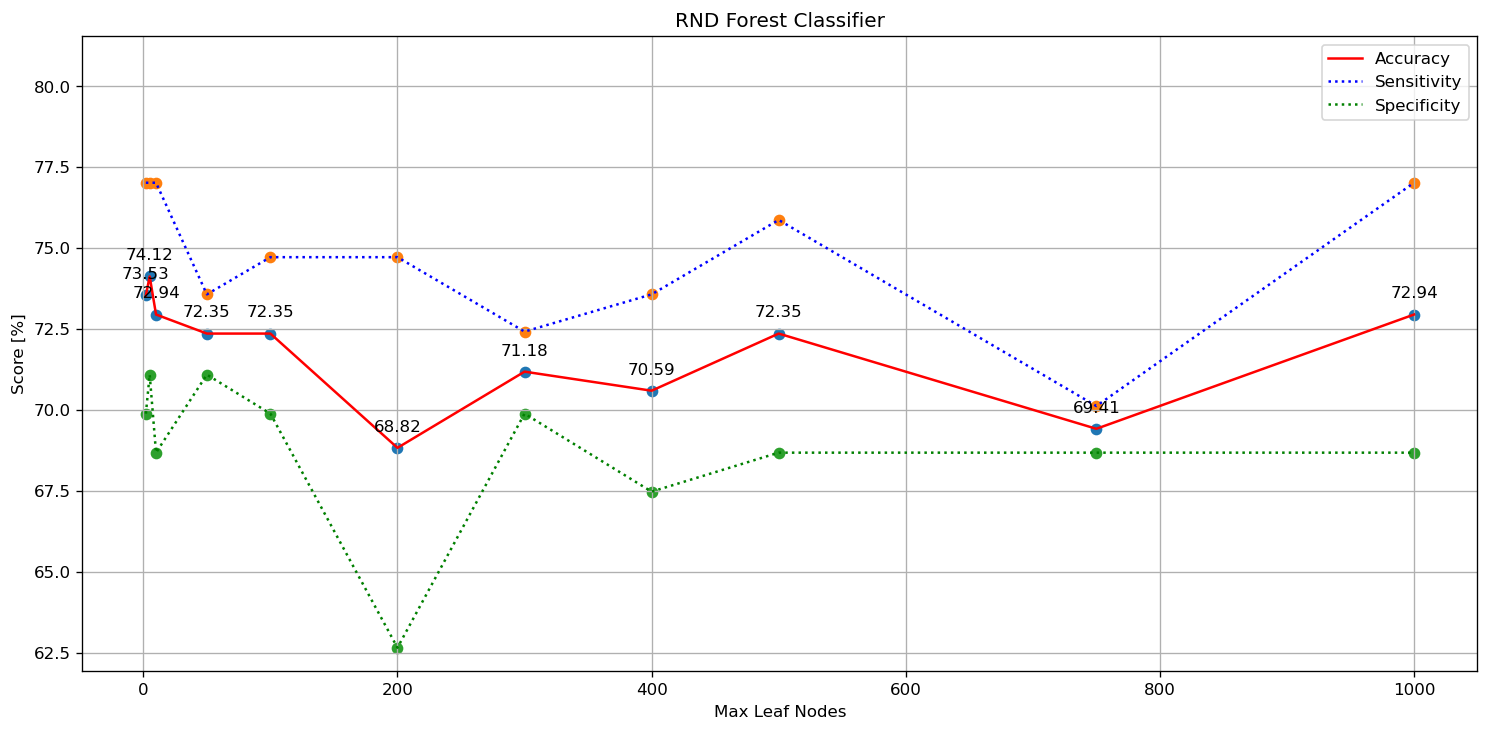

In [243]:
viewer_mode = True
rndF_classifiers = []
if viewer_mode:
    n_ests = [2,5,10,50,100,200,300,400,500,750,1000]
    for n_est in n_ests: # add append to dict like knn
        rndF_classifiers.append(RandomForestClassifier(n_estimators=500, max_depth=20, max_features='sqrt', max_leaf_nodes=n_est))

    acc_list = []
    tpr_list = []
    report_list = []
    true_positive = []
    true_negative = []

    for clf in rndF_classifiers: 
        clf.fit(X_train,y_train)

        y_predict = clf.predict(X_test)
        y_predicted = np.array(y_predict > 0.5, dtype=float)

        rndForest_acc = accuracy_score(y_test, y_predicted)
        cm = confusion_matrix(y_test, y_predicted)
        rndForest_tpr = cm[1][1] /(cm[1][0] + cm[1][1])
        rndForest_report = classification_report(y_test, y_predicted)

        acc_list.append(rndForest_acc)
        tpr_list.append(rndForest_tpr)
        report_list.append(rndForest_report)
        true_positive.append(cm[1][1])
        true_negative.append(cm[0][0])

    plt.figure(figsize=(15, 7))
    ax = ax
    score_list = np.array(acc_list)
    score_list_plot = score_list * 100
    true_positive_plot = np.array(true_positive)/sum(y_test) * 100
    true_negative_plot = np.array(true_negative)/(len(y_test)-sum(y_test)) * 100
    plt.plot(n_ests, score_list_plot,  'r-')
    plt.plot(n_ests, true_positive_plot, 'b:')
    plt.plot(n_ests, true_negative_plot, 'g:')
    plt.scatter(n_ests, score_list_plot)
    plt.scatter(n_ests, true_positive_plot)
    plt.scatter(n_ests, true_negative_plot)
    for x,y in zip(n_ests,score_list_plot):

        label = "{:.2f}".format(y)

        plt.annotate(str(round(y, 2)), # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')

    plt.ylim(min(score_list_plot)* 0.9, max(score_list_plot)*1.1)
    plt.xlabel('Max Leaf Nodes')
    plt.ylabel('Score [%]')
    plt.title('RND Forest Classifier')
    plt.legend(['Accuracy', 'Sensitivity', 'Specificity'])
    plt.grid(True)
    plt.show()

else:
    from sklearn.model_selection import GridSearchCV
    rndForestClassifier = GridSearchCV(estimator=RandomForestClassifier(), param_grid={'n_estimators': [500], 'max_features':['sqrt'], 'max_depth':[20], 'max_leaf_nodes':[500, 1000, 1500]}, cv=5, scoring=['accuracy','recall'], refit='accuracy').fit(X_train, y_train)
    print(rndForestClassifier.best_estimator_)
    param_selection = rndForestClassifier.cv_results_['params']
    test_scores = rndForestClassifier.cv_results_['mean_test_score']
    for i in param_selection:
        print(i)
    print(test_scores)


In [247]:
if viewer_mode:
    rndForest_acc = max(acc_list)
    max_index = np.argmax(acc_list)
    max_nest = n_ests[max_index]
    rndForest_tpr = tpr_list[max_index]
    rndForest_report = report_list[max_index]
    rndForestClassifier = rndF_classifiers[max_index]

    print('Leaf Nodes =', max_nest)
    print('Accuracy =', rndForest_acc)
    print('Sensitivity (TPR) =', rndForest_tpr)
    
    print('\n Confusion matrix \n \n')
    print(rndForest_report)
    #fais le rmse
    from sklearn.metrics import mean_squared_error
    print('RMSE:', mean_squared_error(y_test, y_predicted, squared=False))
else:
    y_predict = rndForestClassifier.predict(X_test)
    y_predicted = np.array(y_predict > 0.5, dtype=float)

    rndForest_acc = accuracy_score(y_test, y_predicted)
    rndForest_report = classification_report(y_test, y_predicted)
    rndForest_cm = confusion_matrix(y_test, y_predicted)
    rndForest_tpr = rndForest_cm[1][1] /(rndForest_cm[1][0] + rndForest_cm[1][1])

    print('Accuracy =', rndForest_acc)
    print('Sensitivity (TPR) =', rndForest_tpr)
    
    print('\n Confusion matrix \n \n')
    print(rndForest_report)
    #fais le rmse
    from sklearn.metrics import mean_squared_error
    print('RMSE:', mean_squared_error(y_test, y_predicted, squared=False))



Leaf Nodes = 5
Accuracy = 0.7411764705882353
Sensitivity (TPR) = 0.7701149425287356

 Confusion matrix 
 

              precision    recall  f1-score   support

           0       0.75      0.71      0.73        83
           1       0.74      0.77      0.75        87

    accuracy                           0.74       170
   macro avg       0.74      0.74      0.74       170
weighted avg       0.74      0.74      0.74       170

RMSE: 0.5201809639866857


In [250]:
import xgboost as xgb
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)
dpred_clf = xgb.DMatrix(df_test, enable_categorical=True)

In [253]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import xgboost as xgb

import xgboost as xgb
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)
dpred_clf = xgb.DMatrix(df_test, enable_categorical=True)

params = {"objective": "multi:softmax","num_class": 3, "tree_method": "hist",
            "learning_rate": 0.3, "max_depth": 6,
            "gamma": 0, "subsample": 1, "colsample_bytree": 1,
            "alpha": 0, "lambda": 1,"random_state": 0}

n = 50
evals = [(dtest_clf, "validation"), (dtrain_clf, "train")]


model = xgb.train(
   params=params,
   dtrain=dtrain_clf,
   num_boost_round=n,
   evals=evals,
   verbose_eval=1,
   # Activate early stopping
   early_stopping_rounds=30
)
preds = model.predict(dtest_clf)
rmse = mean_squared_error(y_test, preds, squared=False)
accuracy = accuracy_score(y_test, preds.round())

print(f"RMSE of the base model: {rmse:.3f}")
print(f"Accuracy of the base model: {accuracy:.3f}") 

from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, preds)



[0]	validation-mlogloss:0.94244	train-mlogloss:0.85494
[1]	validation-mlogloss:0.85030	train-mlogloss:0.70285
[2]	validation-mlogloss:0.79127	train-mlogloss:0.59973
[3]	validation-mlogloss:0.75208	train-mlogloss:0.52498
[4]	validation-mlogloss:0.72209	train-mlogloss:0.46765
[5]	validation-mlogloss:0.69269	train-mlogloss:0.42559
[6]	validation-mlogloss:0.67720	train-mlogloss:0.39219
[7]	validation-mlogloss:0.66720	train-mlogloss:0.36170
[8]	validation-mlogloss:0.66063	train-mlogloss:0.33502
[9]	validation-mlogloss:0.65019	train-mlogloss:0.31676
[10]	validation-mlogloss:0.64646	train-mlogloss:0.30165
[11]	validation-mlogloss:0.64155	train-mlogloss:0.29007
[12]	validation-mlogloss:0.63728	train-mlogloss:0.28018
[13]	validation-mlogloss:0.64227	train-mlogloss:0.26343
[14]	validation-mlogloss:0.63542	train-mlogloss:0.25662
[15]	validation-mlogloss:0.63275	train-mlogloss:0.24446
[16]	validation-mlogloss:0.62737	train-mlogloss:0.23807
[17]	validation-mlogloss:0.62643	train-mlogloss:0.22297
[1

In [225]:
from statsmodels.tsa.stattools import adfuller

# Supposons que votre DataFrame s'appelle df_btc
columns_to_test = [col for col in df_btc.columns if col not in ['date', 'day', 'month', 'year', 'day_of_week']]

for col in columns_to_test:
    result = adfuller(df_btc[col])
    if result[1] > 0.05:
        print(f'ADF Statistic for {col}: {result[0]}')
        print(f'p-value for {col}: {result[1]}')
        print('-------------------------------------')

ADF Statistic for Close_BTC: -1.5035657034209962
p-value for Close_BTC: 0.5317467047237614
-------------------------------------
ADF Statistic for Volume_BTC: -1.2425790570563762
p-value for Volume_BTC: 0.6550164819153466
-------------------------------------


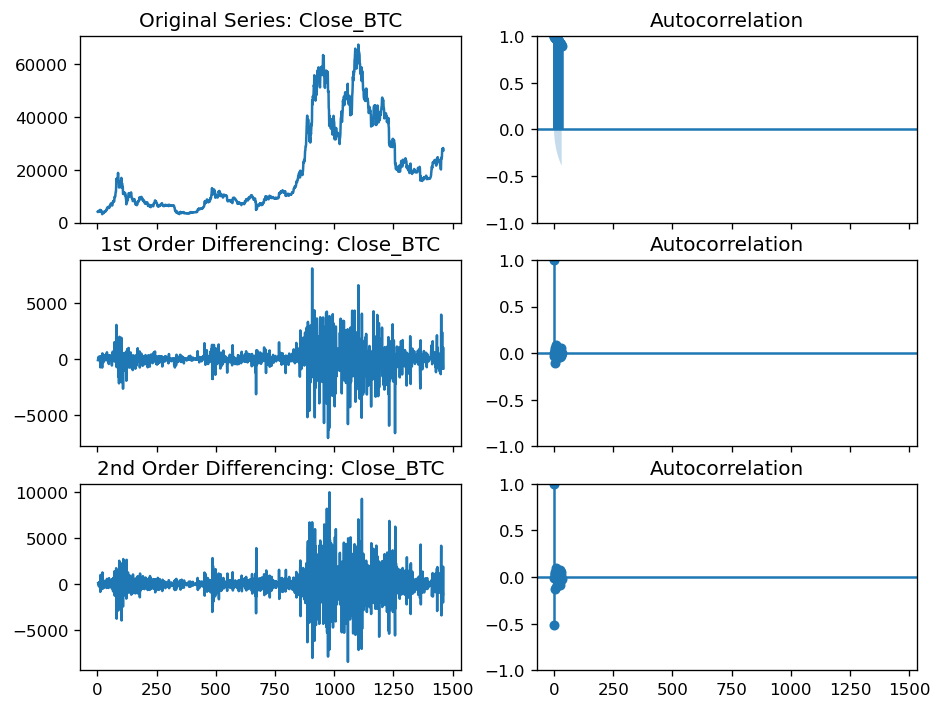

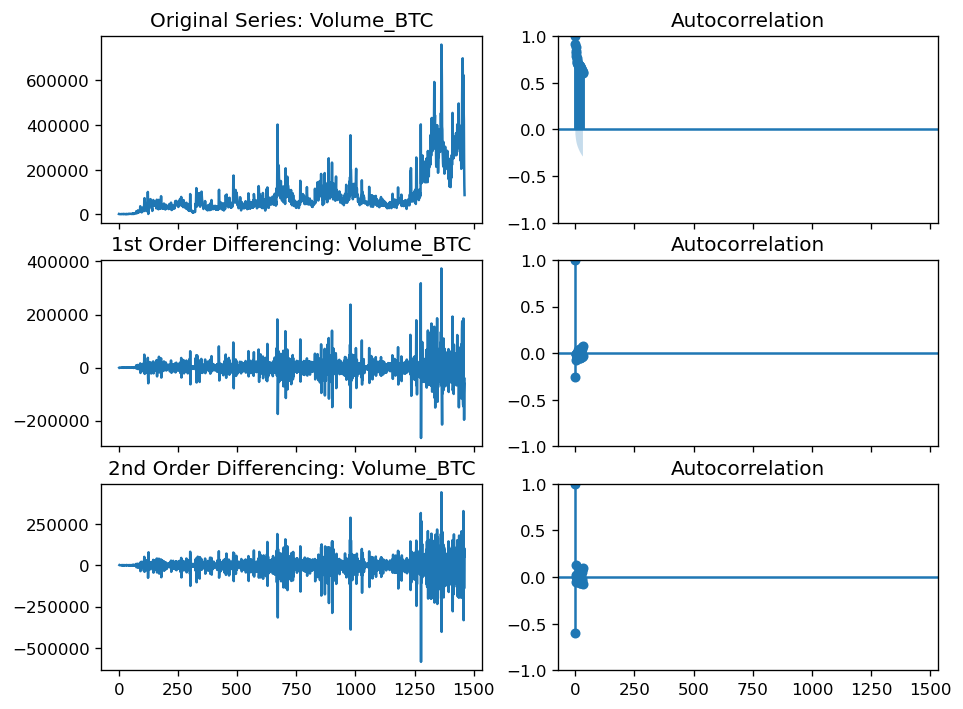

In [226]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Supposons que votre DataFrame s'appelle df_btc
columns_to_test = [col for col in df_btc.columns if col not in ['date', 'day', 'month', 'year', 'day_of_week']]

for col in columns_to_test:
    result = adfuller(df_btc[col])
    if result[1] > 0.05:
        fig, axes = plt.subplots(3, 2, sharex=True)
        
        # Original Series
        axes[0, 0].plot(df_btc[col]); axes[0, 0].set_title(f'Original Series: {col}')
        plot_acf(df_btc[col], ax=axes[0, 1])

        # 1st Differencing
        axes[1, 0].plot(df_btc[col].diff()); axes[1, 0].set_title(f'1st Order Differencing: {col}')
        plot_acf(df_btc[col].diff().dropna(), ax=axes[1, 1])

        # 2nd Differencing
        axes[2, 0].plot(df_btc[col].diff().diff()); axes[2, 0].set_title(f'2nd Order Differencing: {col}')
        plot_acf(df_btc[col].diff().diff().dropna(), ax=axes[2, 1])

        plt.show()

In [227]:
# #fais une diff sur les colonnes qui ont une pvlaue inférieur a 0.05
# df_btc['Close_BTC'] = df_btc['Close_BTC'].diff()
# df_btc['Volume_BTC'] = df_btc['Volume_BTC'].diff()
# #drop la premiere ligne du df 
# df_btc = df_btc.drop(df_btc.index[0])

In [228]:
# import matplotlib.pyplot as plt

# # Supposons que votre DataFrame s'appelle df_btc
# columns_to_plot = [col for col in df_btc.columns if col not in ['date', 'day', 'month', 'year', 'day_of_week']]

# for col in columns_to_plot:
#     plt.figure(figsize=(10, 6))
#     plt.plot(df_btc['date'], df_btc[col])
#     plt.title(col)
#     plt.xlabel('date')
#     plt.ylabel(col)
#     plt.show()

In [229]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM

# Convertir toutes les colonnes en numérique
series = df_train.apply(pd.to_numeric, errors='coerce')

# Créer un modèle VAR sur les séries différenciées 
model = VAR(series.dropna()) # Modèle VAR en niveau car il y a le meme nombre de cointégration que de variables

# Déterminer le nombre optimal de retards
lags = model.select_order(maxlags=12)
optimal_lags = lags.selected_orders['aic']
print(f'Optimal number of lags: {optimal_lags}')

# Vérifier la cointégration
johansen_test = coint_johansen(series, 1, optimal_lags)
print(f"Trace statistics: {johansen_test.lr1}")
print(f"Eigenvalues: {johansen_test.eig}")
print(f"Cointegration vectors: {johansen_test.evec}")
# Afficher les valeurs critiques
print(f"Critical values: {johansen_test.cvt}")

# Ajuster le modèle VAR avec le nombre optimal de retards
model_results = model.fit(optimal_lags)

# Afficher les résultats
print(model_results.summary())

# Créer le modèle VECM
vecm_model = VECM(series, k_ar_diff=optimal_lags, coint_rank=4, deterministic="ci")
vecm_results = vecm_model.fit()

alpha = vecm_results.alpha
print(f"Adjustment coefficients (Alpha): {alpha}")
# Afficher les résultats
print(vecm_results.summary())

# Faire des prédictions
predictions_var = model_results.forecast(series.values[-optimal_lags:], steps=len(df_test))
predictions_vecm = vecm_results.predict(steps=len(df_test))

/Users/VerTebr0/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


Optimal number of lags: 10
Trace statistics: [1.60187113e+03 1.25440021e+03 1.06199124e+03 8.71444841e+02
 7.06881212e+02 5.73269198e+02 4.45995443e+02 3.32515120e+02
 2.42919700e+02 1.67970100e+02 1.18080605e+02 7.83103965e+01
 4.37914354e+01 2.00888869e+01 4.04320664e+00 7.02726766e-10]
Eigenvalues: [2.37735490e-01 1.39566982e-01 1.38314027e-01 1.20643892e-01
 9.91210546e-02 9.46490507e-02 8.48401249e-02 6.76028440e-02
 5.68730434e-02 3.82263698e-02 3.05927489e-02 2.66075504e-02
 1.83472184e-02 1.24574433e-02 3.15377157e-03 5.49055159e-13]
Cointegration vectors: [[ 5.89762200e-06  8.59442995e-06  1.70989166e-05 -5.66245006e-07
   2.78859051e-05 -8.38649007e-06 -1.83322492e-05  2.93151053e-05
   2.20384599e-05 -1.11894261e-05  3.03425796e-05 -2.43356399e-05
   8.85754973e-05 -7.18602473e-06 -7.35401677e-05 -4.74662748e-06]
 [-5.48851499e-07 -1.71356147e-06  6.09554022e-06 -3.97032742e-06
   6.76809115e-06 -1.77311887e-06  3.78826698e-06  1.53052311e-06
   6.81981522e-07  2.20497278e-0

/var/folders/bn/74x_l6t57mncrtd65lq_drbw0000gn/T/ipykernel_27050/2345034636.py:17: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  johansen_test = coint_johansen(series, 1, optimal_lags)
/Users/VerTebr0/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/var_model.py:1559: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 19, Jan, 2024
Time:                     17:38:04
--------------------------------------------------------------------
No. of Equations:         16.0000    BIC:                   -51.4164
Nobs:                     1281.00    HQIC:                  -57.8909
Log likelihood:           13065.8    FPE:                1.50322e-27
AIC:                     -61.7836    Det(Omega_mle):     2.26133e-28
--------------------------------------------------------------------
Results for equation Close_BTC
                                          coefficient             std. error           t-stat            prob
-------------------------------------------------------------------------------------------------------------
const                                      893.970530       280683356.570809            0.000           1.000
L1.Close_BTC                                 0.993

/Users/VerTebr0/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/VerTebr0/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/vecm.py:1547: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params_default))
/Users/VerTebr0/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/vecm.py:1583: RuntimeWarning: invalid value encountered in sqrt
  last_rows_1d = np.sqrt(np.diag(mat1.dot(mat2)))


        Det. terms outside the coint. relation & lagged endog. parameters for equation Close_BTC        
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
L1.Close_BTC                         -6.952e+05   2.95e+18  -2.36e-13      1.000   -5.78e+18    5.78e+18
L1.Volume_BTC                        -1.148e+04   1.17e+17  -9.78e-14      1.000    -2.3e+17     2.3e+17
L1.btc_tweet_count                   -5.474e+05    1.2e+19  -4.56e-14      1.000   -2.35e+19    2.35e+19
L1.btc_posts_count                    1.361e+08   1.85e+21   7.35e-14      1.000   -3.63e+21    3.63e+21
L1.btc_textblob_polarity_min         -1.255e+10   3.11e+22  -4.04e-13      1.000   -6.09e+22    6.09e+22
L1.btc_textblob_polarity_max         -2.257e+10   3.56e+22  -6.33e-13      1.000   -6.98e+22    6.98e+22
L1.btc_textblob_polarity_mean        -9.551e+09   6.07e

/Users/VerTebr0/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/var_model.py:81: RuntimeWarning: invalid value encountered in add
  phis[i] += np.dot(phis[i - j], coefs[j - 1])
/Users/VerTebr0/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/var_model.py:201: RuntimeWarning: overflow encountered in matmul
  var = phi @ sigma_u @ phi.T
/Users/VerTebr0/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/var_model.py:202: RuntimeWarning: invalid value encountered in add
  forc_covs[h] = prior = prior + var
/Users/VerTebr0/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/var_model.py:201: RuntimeWarning: invalid value encountered in matmul
  var = phi @ sigma_u @ phi.T
/Users/VerTebr0/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/var_model.py:298: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(_forecast_vars(steps, ma_coefs, sig_u))


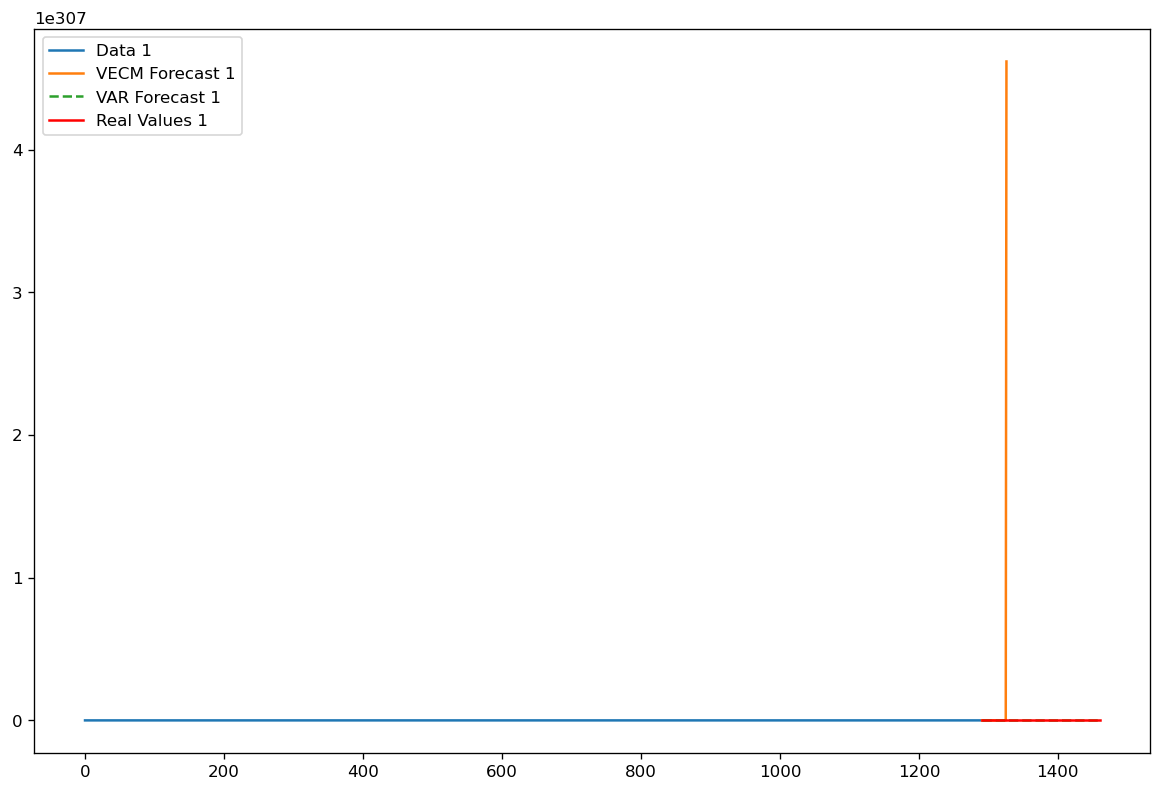

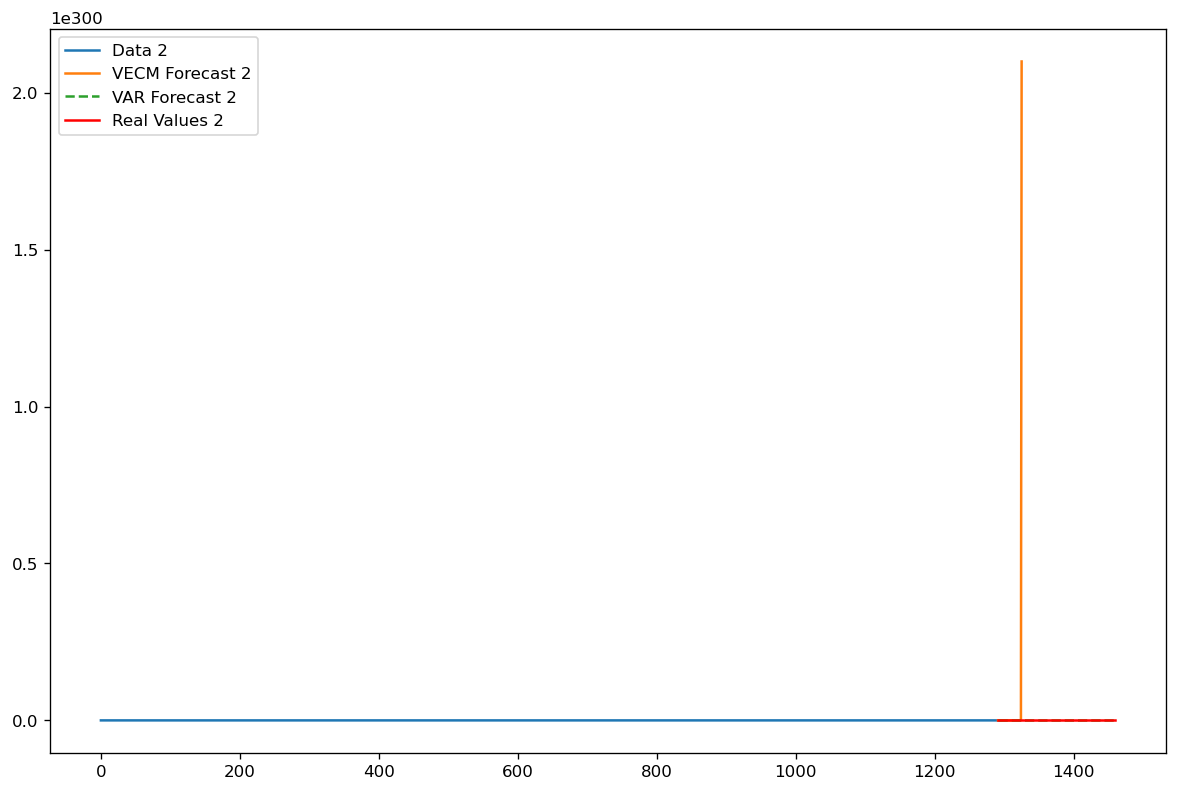

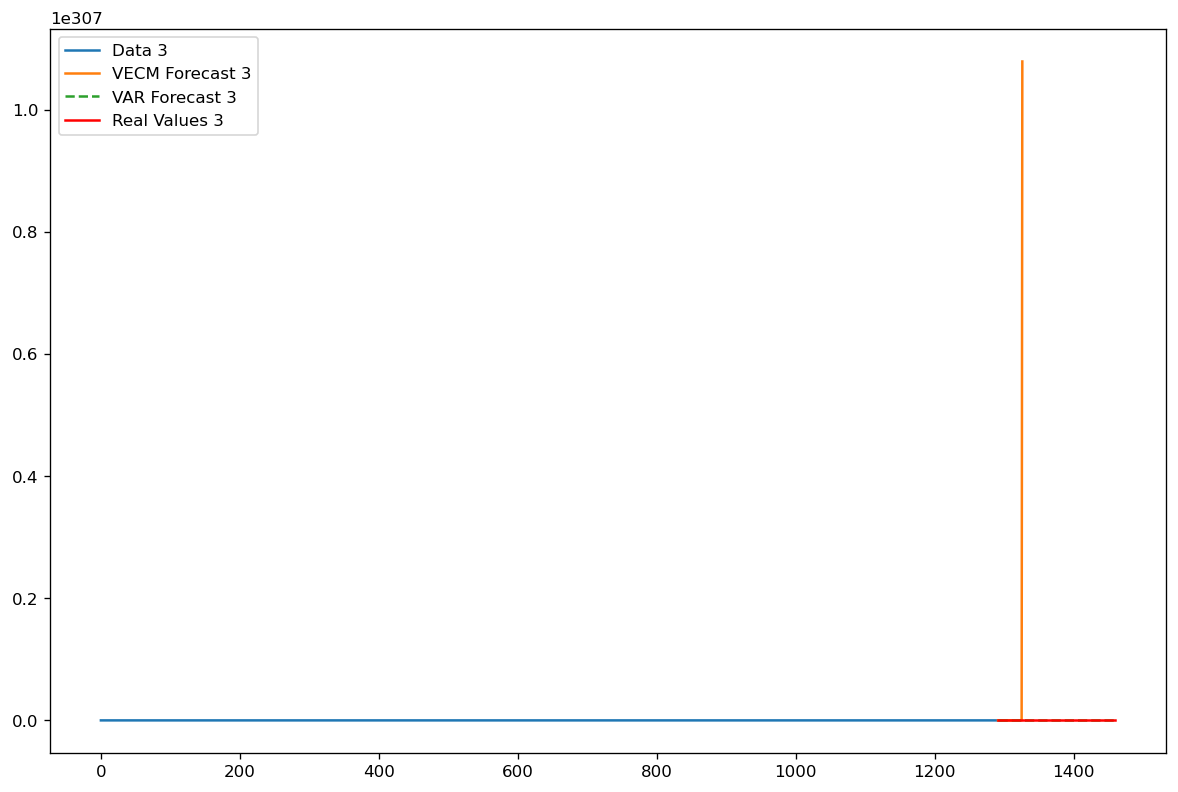

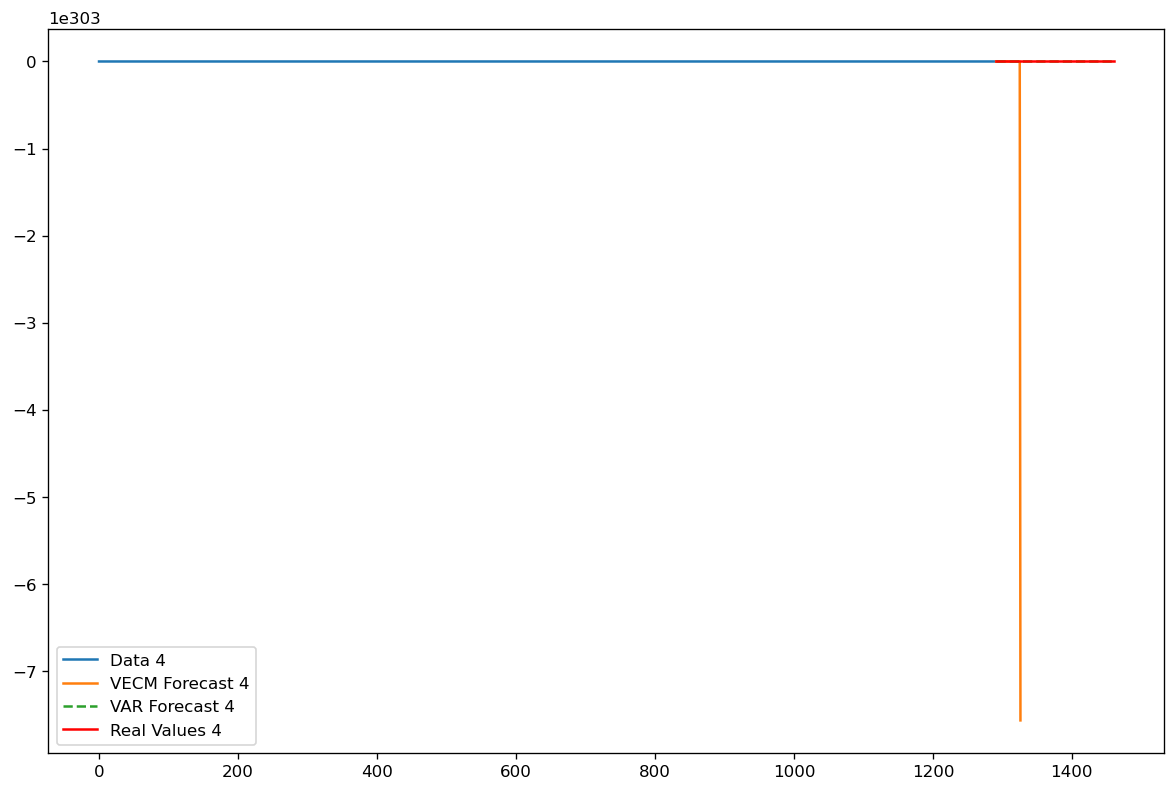

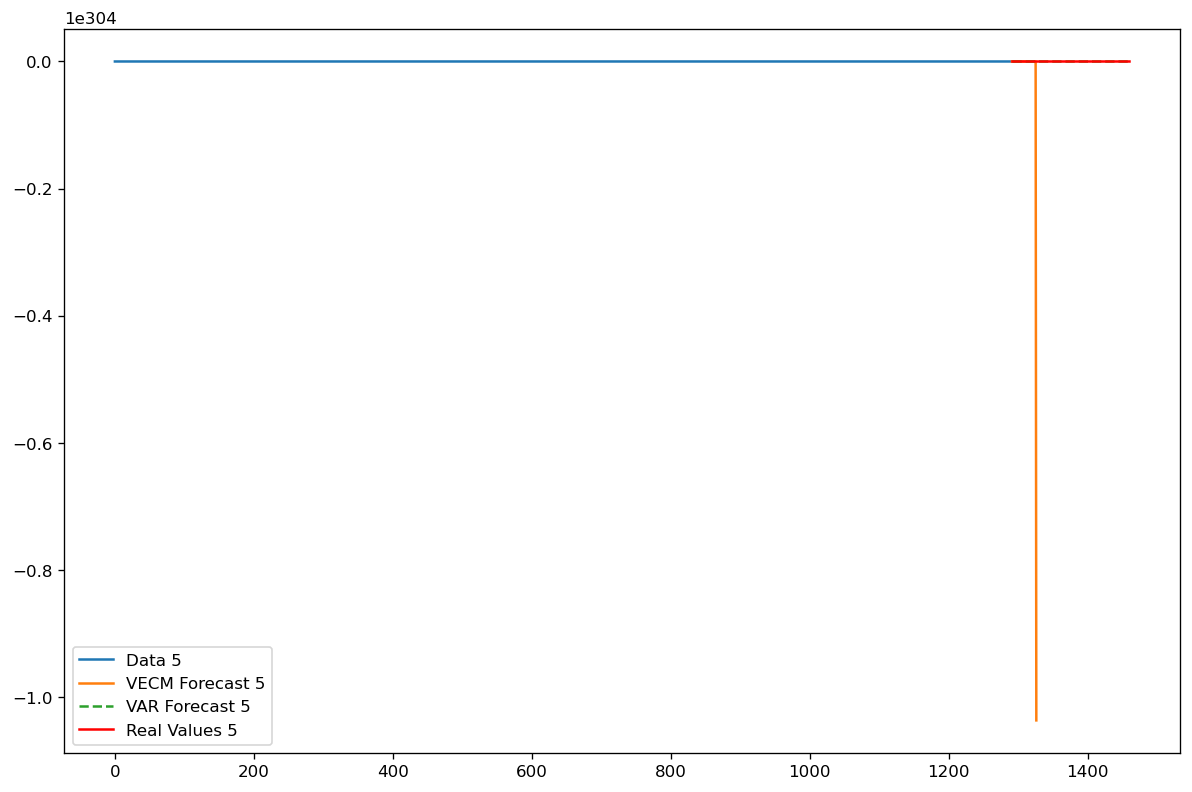

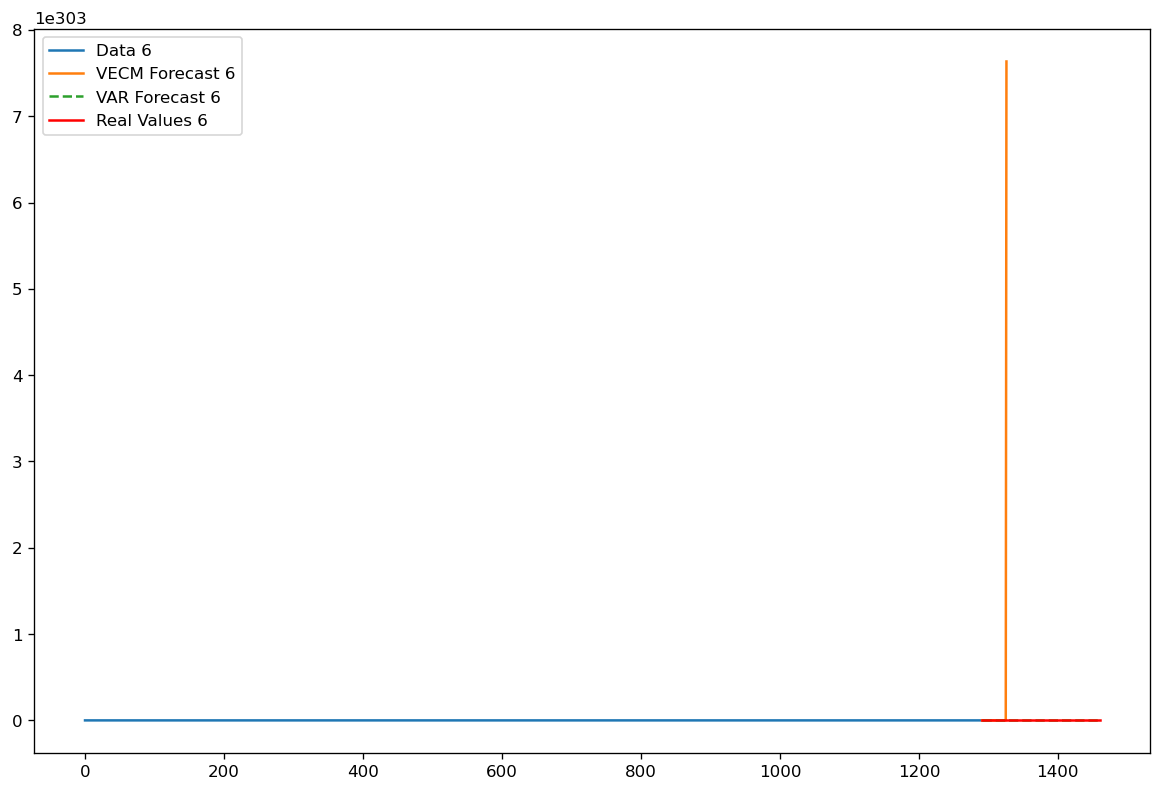

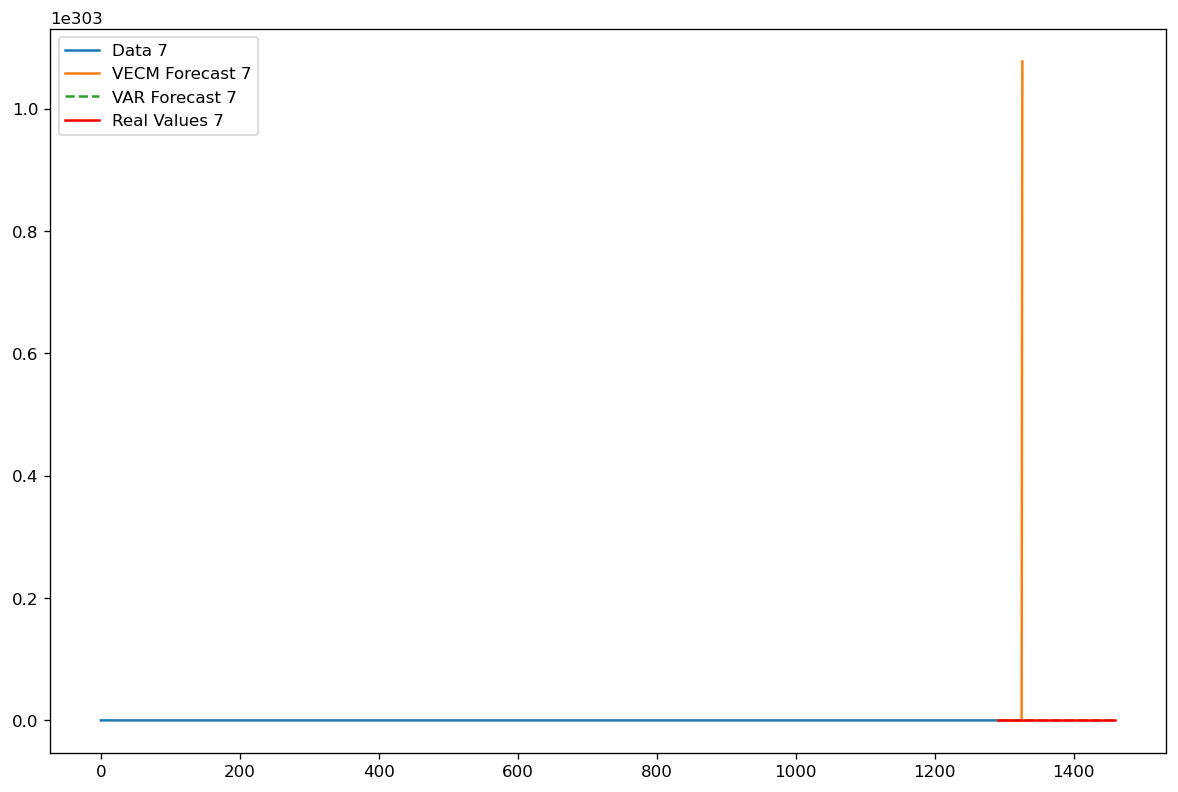

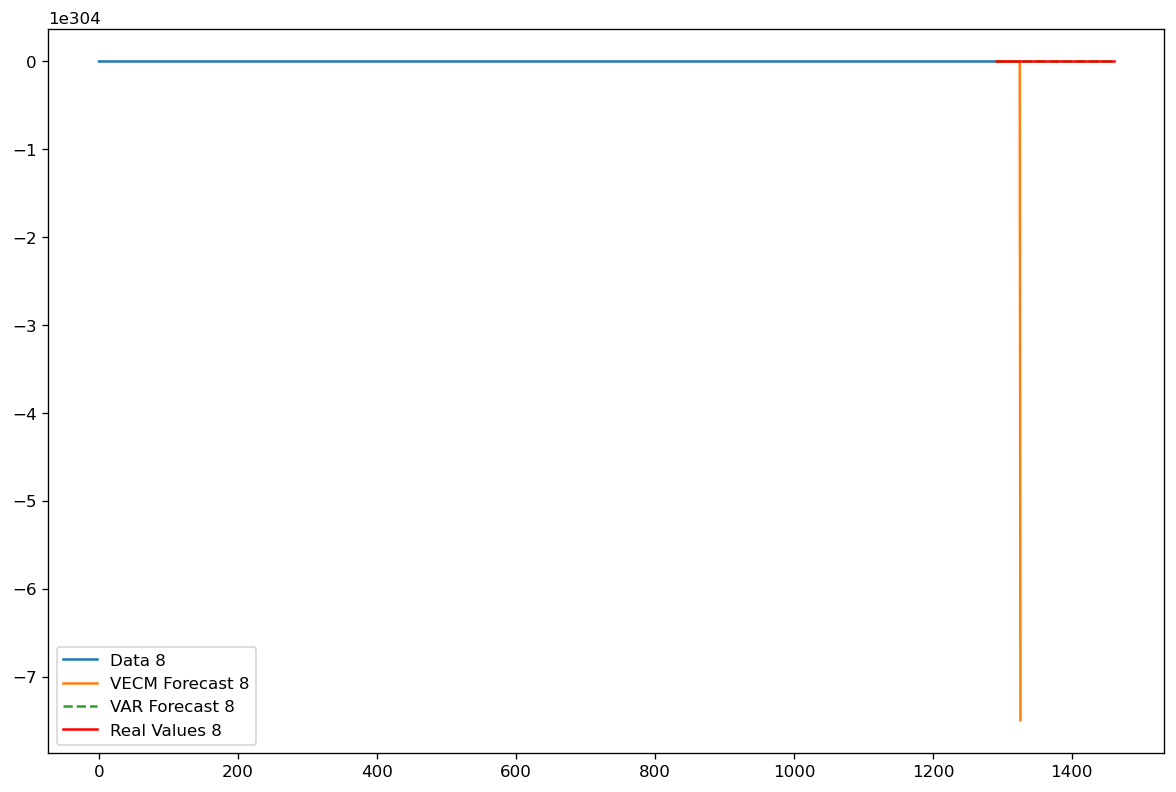

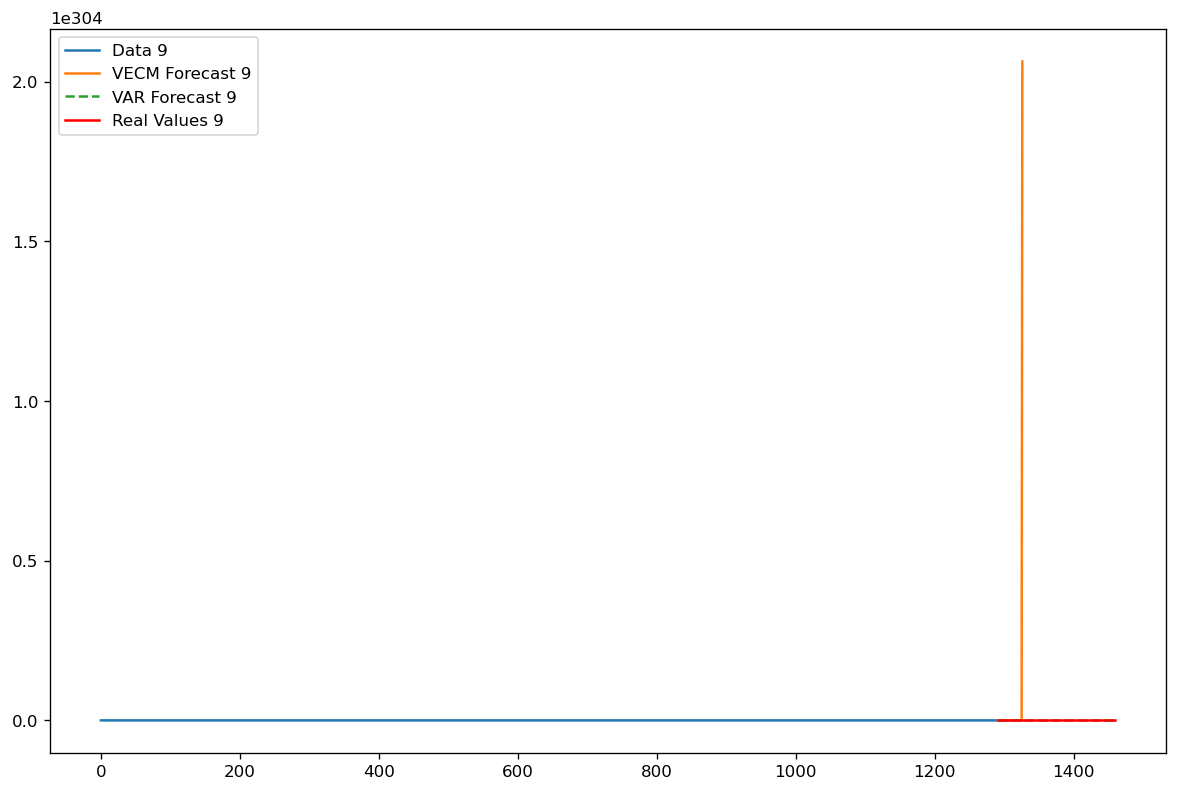

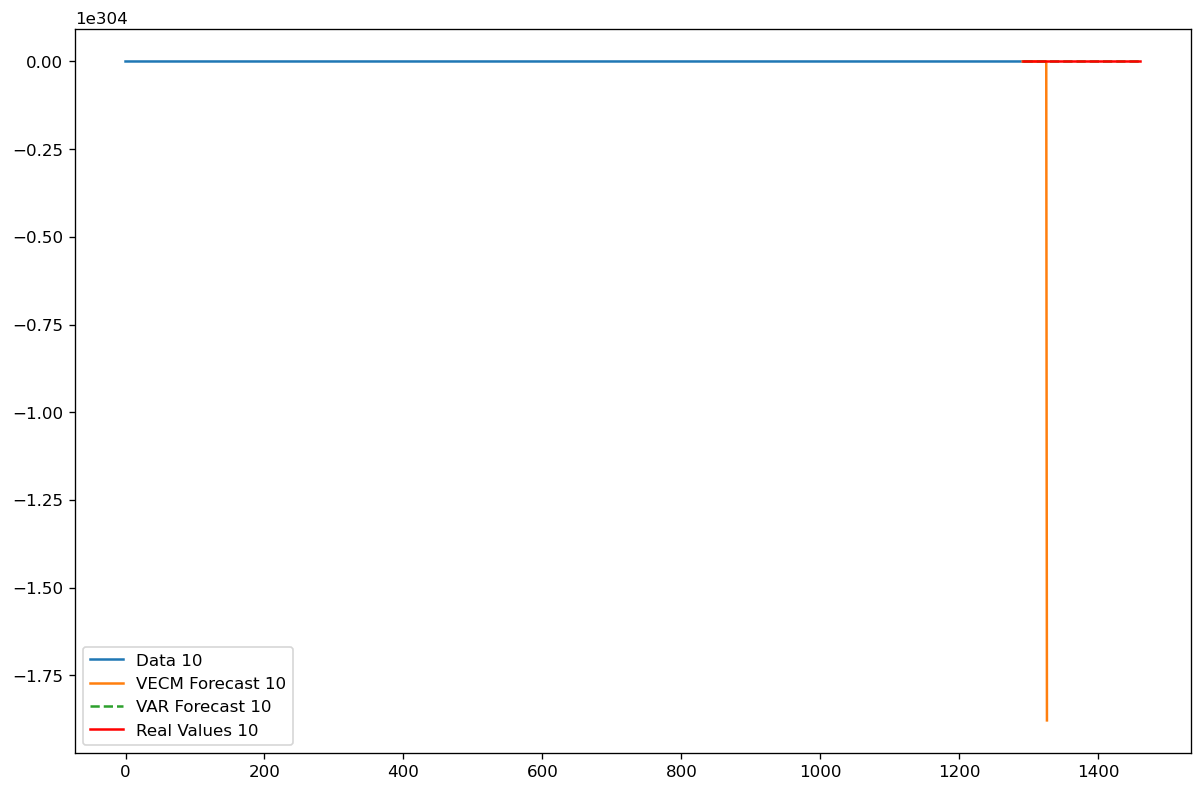

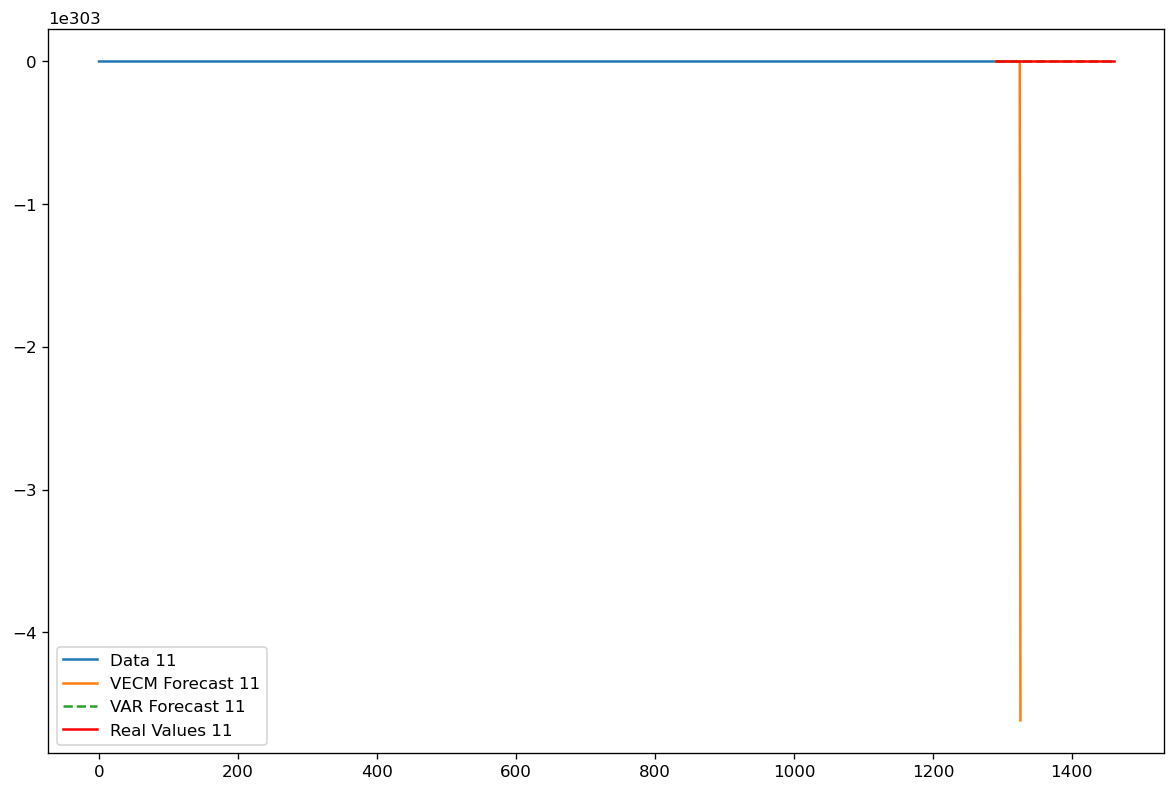

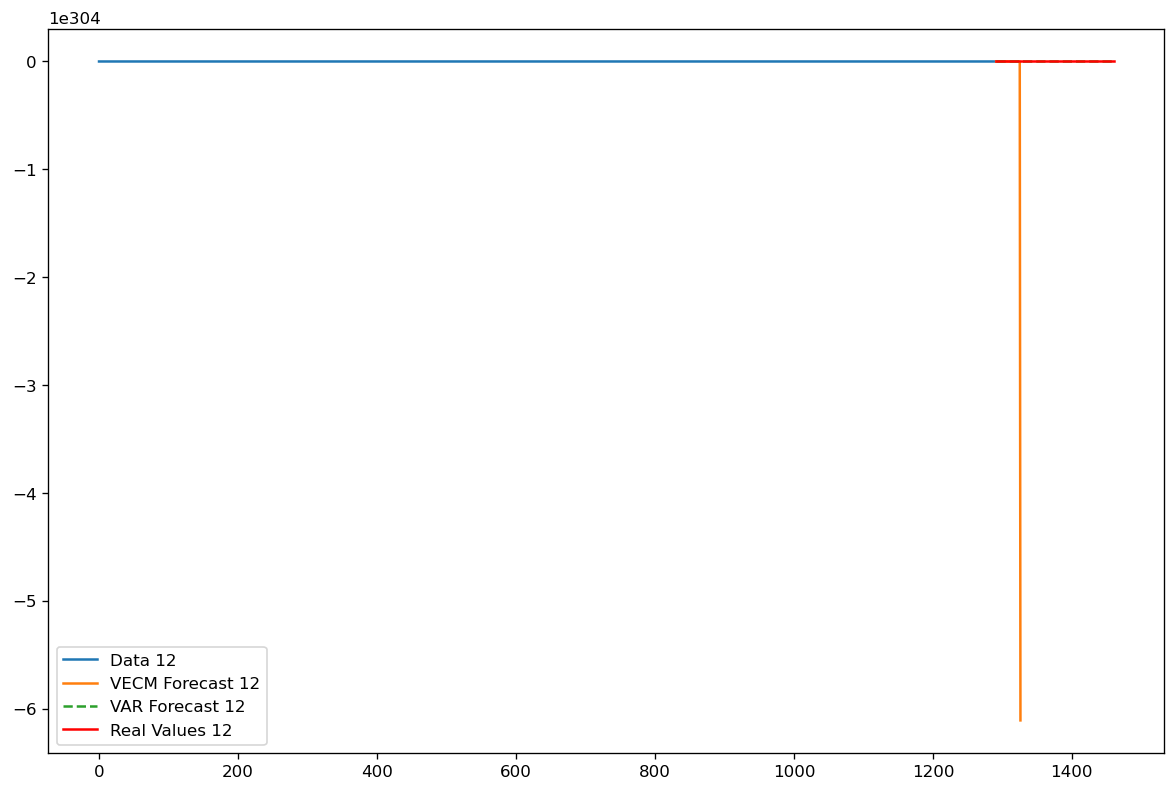

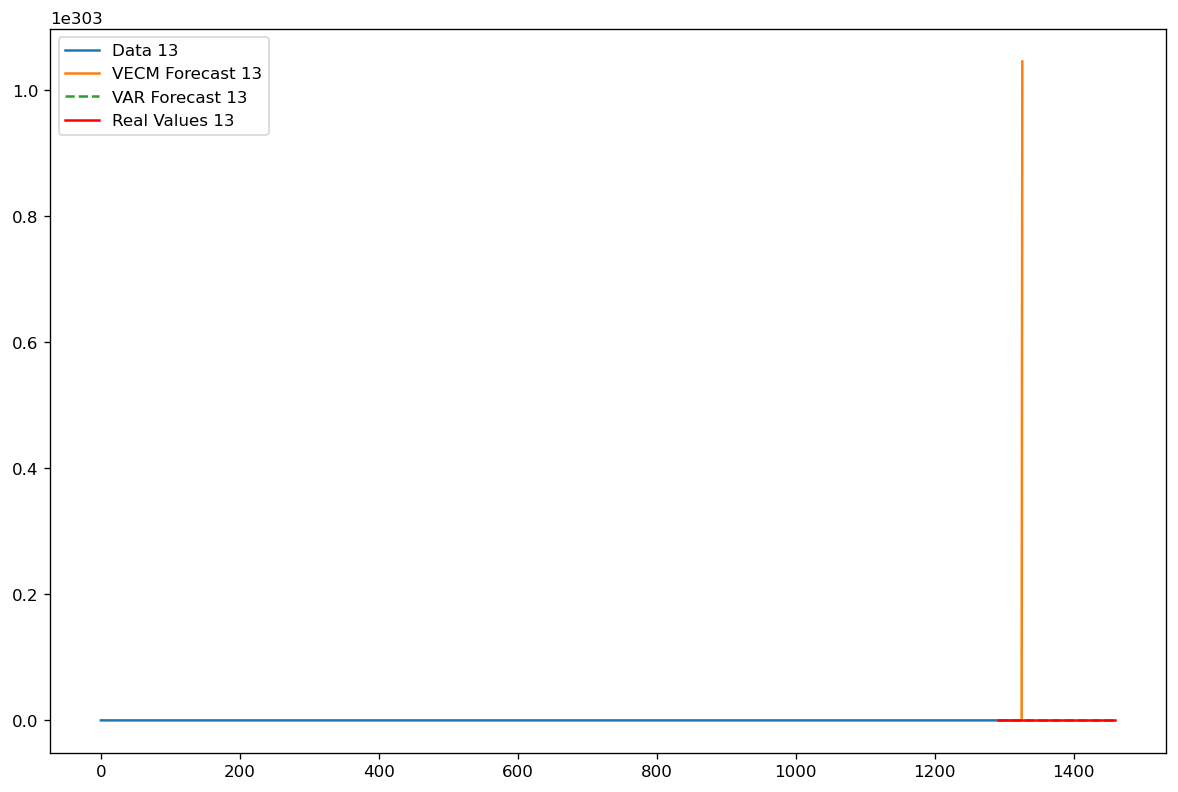

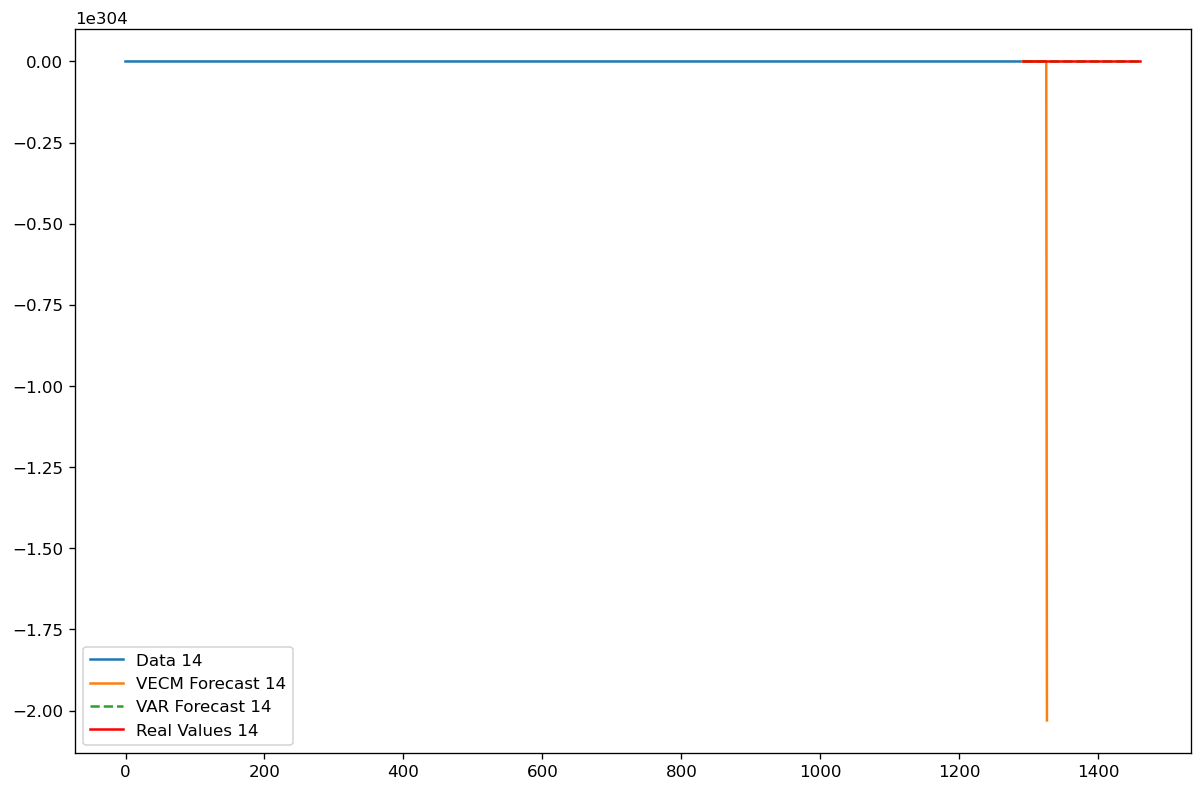

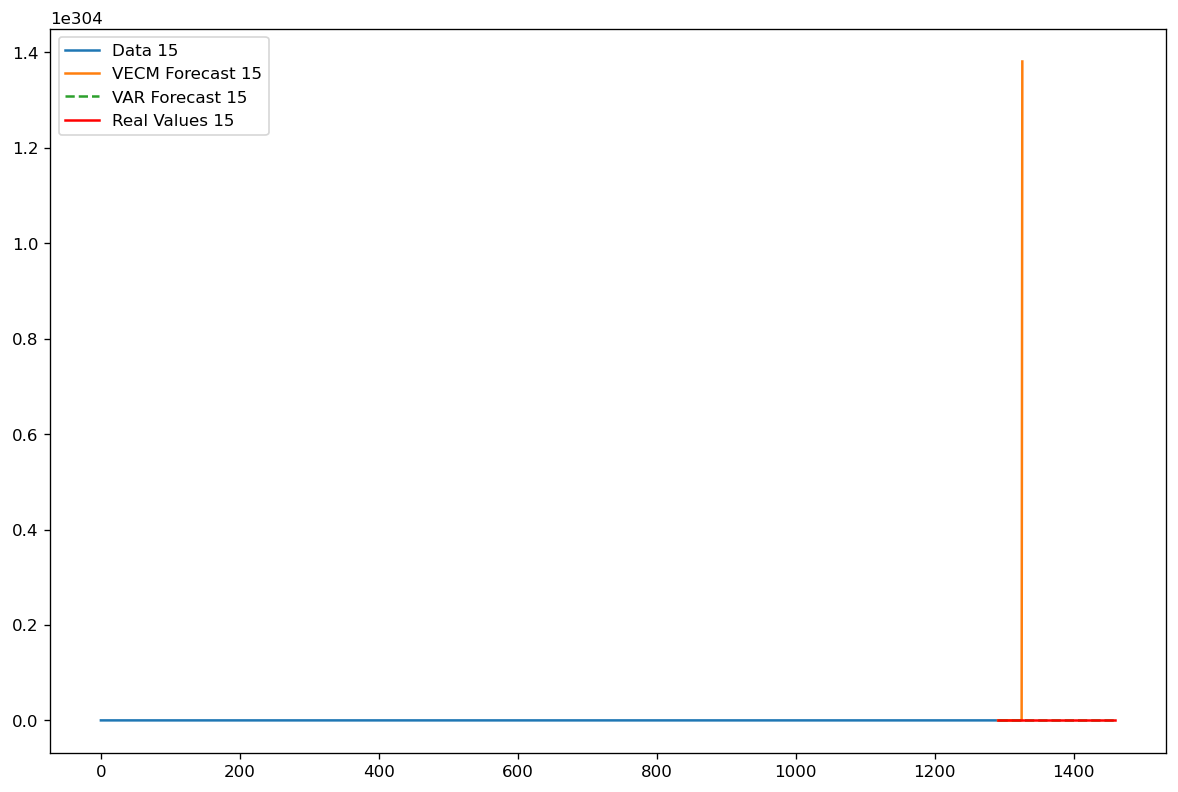

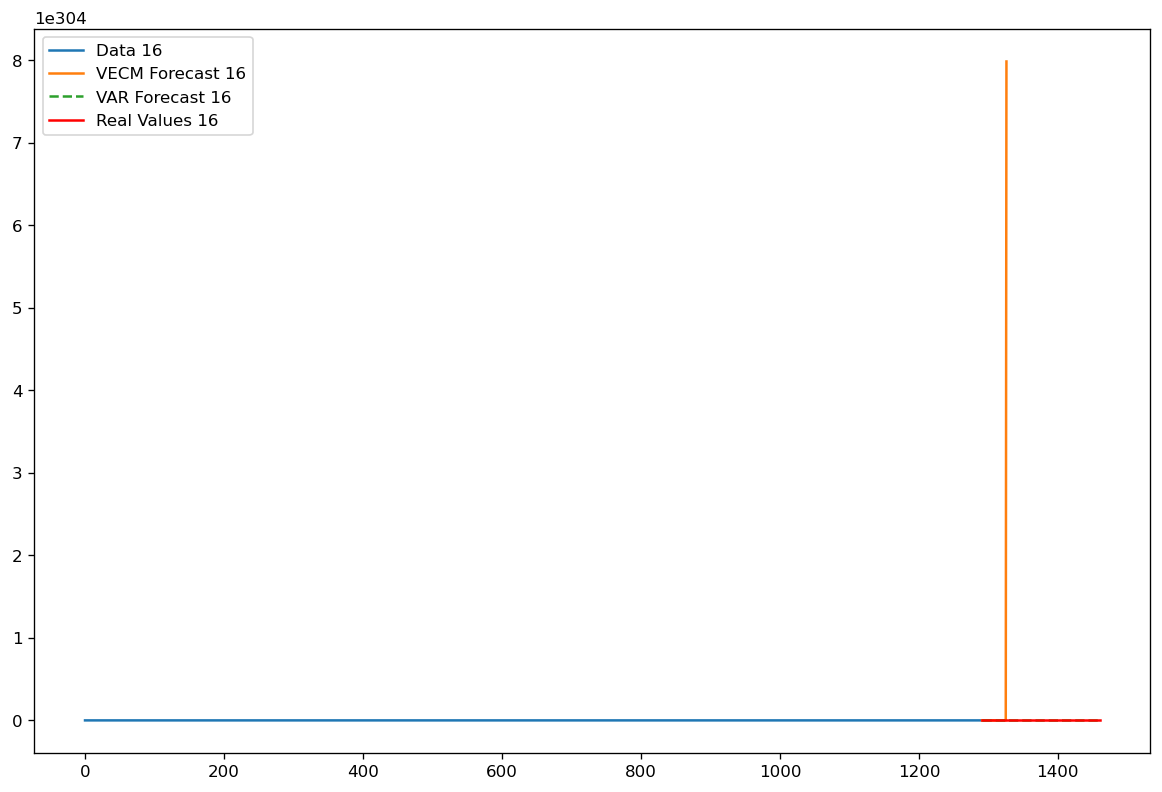

In [230]:
import matplotlib.pyplot as plt
import numpy as np

# Convertir le DataFrame en un tableau numpy
series_np = series.to_numpy()

# Prévoir 10 périodes à l'avance avec intervalle de confiance
forecasts, lower, upper = vecm_results.predict(steps=len(df_test), alpha=0.05)

# Prévoir 10 périodes à l'avance avec le modèle VAR
predictions_var = model_results.forecast(series.values[-optimal_lags:], steps=len(df_test))

# Extraire les valeurs réelles de la période de prévision
real_values = df_test.to_numpy()

# Tracer les données réelles et les prévisions pour chaque dimension
for i in range(forecasts.shape[1]):
    # Définir la taille de la figure
    plt.figure(figsize=(12, 8))
    
    # Sélectionner la i-ème dimension
    forecasts_i = forecasts[:, i]
    lower_i = lower[:, i]
    upper_i = upper[:, i]
    predictions_var_i = predictions_var[:, i]
    real_values_i = real_values[:, i]

    # Tracer les données réelles
    plt.plot(series_np[:, i], label=f'Data {i+1}')

    # Tracer les prévisions du modèle VECM
    forecast_index = np.arange(len(series_np), len(series_np) + len(forecasts_i))
    plt.plot(forecast_index, forecasts_i, label=f'VECM Forecast {i+1}')

    # Tracer les prévisions du modèle VAR
    plt.plot(forecast_index, predictions_var_i, label=f'VAR Forecast {i+1}', linestyle='--')

    # Tracer les valeurs réelles de la période de prévision
    plt.plot(forecast_index, real_values_i, label=f'Real Values {i+1}', color='red')

    # Tracer l'intervalle de confiance
    plt.fill_between(forecast_index, lower_i, upper_i, color='k', alpha=.15)

    plt.legend()
    plt.show()